Libraries

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

In [9]:
def getSymbolReport(symbol:str) -> str:
    """
    Get required financial report for the desired symbol.
    symbol: Symbol
    """
    ticker = yf.Ticker(symbol)
    info_dict = ticker.get_info()
    news_list = ticker.get_news()
    institutional_holders = ticker.get_institutional_holders()
    mutualfund_holders = ticker.get_mutualfund_holders()   
    income_stmt = ticker.get_income_stmt() 

    def getCompanyInfo(info_dict:dict) -> str: 

        sel_fields = ['longName','website','sector','industry','longBusinessSummary','fullTimeEmployees','companyOfficers']
        s = f"## **{info_dict['longName']}**<br>\n"
        for field in sel_fields:
            if field == 'longBusinessSummary':
                s += f"\n### **Business Summary**<br>\n{info_dict[field]}"
                continue
            elif field == 'fullTimeEmployees':
                s += "\n### **Employee Details**<br>\n"
            elif field == 'companyOfficers':
                s += 'majorEmployees:<br>\n'
                for officer in info_dict['companyOfficers']:
                    s += f"- {officer['name']}: {officer['title']}<br>\n"
                continue
            s += f"{field}: " + str(info_dict[field]) + "<br>\n"
        return s
    
    def getCompanyNews(news_list:list) -> str:

        sel_fields = ['title','link','publisher']
        s = f"### **Recent Company News**<br>\n"
        for news in news_list:
            for field in sel_fields:
                s += f"{field}: " + f"{news[field]}<br>\n"
            s += "<br>\n"
        return s
    
    def getInvestorData(df1:pd.DataFrame, df2:pd.DataFrame) -> str:

        # Institutional Holders and Percentage Holding
        plt.figure()
        plt.title('Institutional Holders and Percentage Holding')
        plt.pie(df1['Shares'],normalize=True,labels=df1['Holder'])
        plt.pie(df1['Shares'],normalize=True,labels=round((df1['Shares']/df1['Shares'].sum())*100,3),labeldistance=0.5,rotatelabels=True)
        plt.savefig('./ReportMedia/Institutional_Holders_and_Percentage_Holding.png')
        
        # Mutual_Fund_Holders_and_Percentage_Holding
        plt.figure()
        plt.title('Mutual Fund Holders and Percentage Holding')
        plt.pie(df2['Shares'],normalize=True,labels=df2['Holder'])
        plt.pie(df2['Shares'],normalize=True,labels=round((df2['Shares']/df2['Shares'].sum())*100,3),labeldistance=0.5,rotatelabels=True)
        plt.savefig('./ReportMedia/Mutual_Fund_Holders_and_Percentage_Holding.png')

        s = "### **Investor Data**<br>\n![Institutional Holders and Percentage Holding](./ReportMedia/Institutional_Holders_and_Percentage_Holding.png)<br>\n![Mutual_Fund_Holders_and_Percentage_Holding](./ReportMedia/Mutual_Fund_Holders_and_Percentage_Holding.png)<br>\n"
        return s
    
    def getFinancials(df1:dict, df2:pd.DataFrame):
        sel_fields1 = ['totalRevenue','totalDebt','totalCash','enterpriseValue','bookValue','marketCap',     'currentRatio','quickRatio',    'debtToEquity','dividendRate','dividendYield','fiveYearAvgDividendYield','earningsGrowth','earningsQuarterlyGrowth','enterpriseToEbitda','enterpriseToRevenue','payoutRatio','priceToBook','profitMargins','returnOnAssets','returnOnEquity','revenueGrowth','revenuePerShare','totalCashPerShare']
        sel_fields2 = ['EBITDA','EBIT','InterestExpense','InterestIncome','TotalExpenses','NetIncome','TotalRevenue','GrossProfit','BasicEPS','ResearchAndDevelopment']
        s = '### **Latest Financials**<br>\n#### General Financials<br>\n'
        for field in sel_fields1:
            if field == 'currentRatio':








    return getCompanyInfo(ticker = ticker,info_dict = info_dict) + getCompanyNews(ticker = ticker, news_list = news_list) + getInvestorData(ticker = ticker, df1 = institutional_holders, df2 = mutualfund_holders) + getFinancials(df1 = info_dict, df2 = income_stmt)

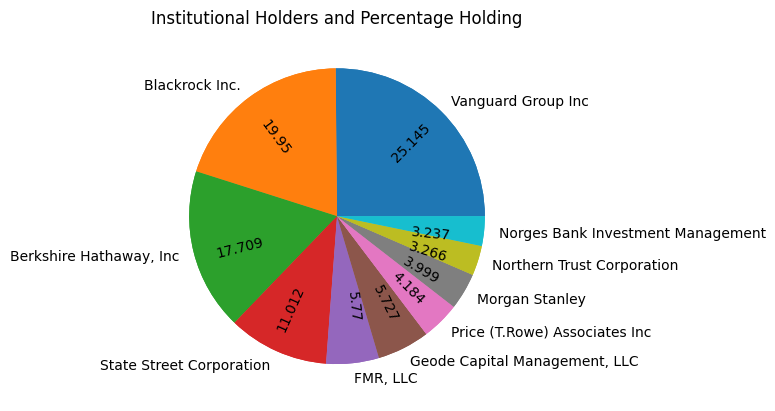

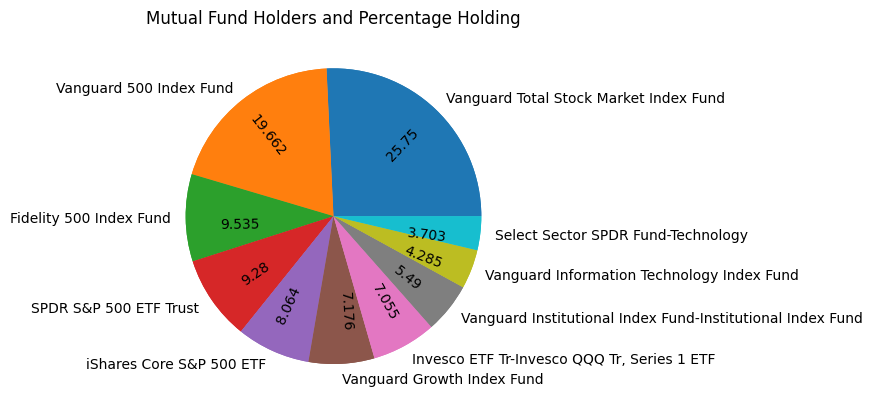

In [11]:
symbol = 'AAPL'
with open('Report.md','w') as file:
    file.write(getSymbolReport(symbol = symbol))
file.close()

## **Apple Inc.**<br>
longName: Apple Inc.<br>
website: https://www.apple.com<br>
sector: Technology<br>
industry: Consumer Electronics<br>

### **Business Summary**<br>
Apple Inc. designs, manufactures, and markets smartphones, personal computers, tablets, wearables, and accessories worldwide. The company offers iPhone, a line of smartphones; Mac, a line of personal computers; iPad, a line of multi-purpose tablets; and wearables, home, and accessories comprising AirPods, Apple TV, Apple Watch, Beats products, and HomePod. It also provides AppleCare support and cloud services; and operates various platforms, including the App Store that allow customers to discover and download applications and digital content, such as books, music, video, games, and podcasts. In addition, the company offers various services, such as Apple Arcade, a game subscription service; Apple Fitness+, a personalized fitness service; Apple Music, which offers users a curated listening experience with on-demand radio stations; Apple News+, a subscription news and magazine service; Apple TV+, which offers exclusive original content; Apple Card, a co-branded credit card; and Apple Pay, a cashless payment service, as well as licenses its intellectual property. The company serves consumers, and small and mid-sized businesses; and the education, enterprise, and government markets. It distributes third-party applications for its products through the App Store. The company also sells its products through its retail and online stores, and direct sales force; and third-party cellular network carriers, wholesalers, retailers, and resellers. Apple Inc. was founded in 1976 and is headquartered in Cupertino, California.
### **Employee Details**<br>
fullTimeEmployees: 161000<br>
majorEmployees:<br>
- Mr. Timothy D. Cook: CEO & Director<br>
- Mr. Luca  Maestri: CFO & Senior VP<br>
- Mr. Jeffrey E. Williams: Chief Operating Officer<br>
- Ms. Katherine L. Adams: Senior VP, General Counsel & Secretary<br>
- Ms. Deirdre  O'Brien: Senior Vice President of Retail<br>
- Mr. Chris  Kondo: Senior Director of Corporate Accounting<br>
- Mr. James  Wilson: Chief Technology Officer<br>
- Suhasini  Chandramouli: Director of Investor Relations<br>
- Mr. Greg  Joswiak: Senior Vice President of Worldwide Marketing<br>
- Mr. Adrian  Perica: Head of Corporate Development<br>
### **Recent Company News**<br>
title: Apple's 'Find My' Feature Helps An iPhone Owner Recover Their Stolen Phone From Walmart's 'EcoATM': Here's How You Can Save Yours<br>
link: https://finance.yahoo.com/news/apples-feature-helps-iphone-owner-093913073.html<br>
publisher: Benzinga<br>
<br>
title: Investors see Microsoft's stock market value leaving Apple behind<br>
link: https://finance.yahoo.com/news/investors-see-microsofts-stock-market-080338838.html<br>
publisher: Reuters<br>
<br>
title: Dow Jones Futures Fall; Microsoft Leads Huge Wave Of Tech Earnings<br>
link: https://finance.yahoo.com/m/6d4f2560-a67a-3f79-bd51-03f8adf7b162/dow-jones-futures-fall%3B.html<br>
publisher: Investor's Business Daily<br>
<br>
title: A Fed meeting, big tech earnings and the January jobs report: What to know this week<br>
link: https://finance.yahoo.com/news/a-fed-meeting-big-tech-earnings-and-the-january-jobs-report-what-to-know-this-week-181304626.html<br>
publisher: Yahoo Finance<br>
<br>
title: Why Qualcomm Could Be a Top AI Stock for 2024<br>
link: https://finance.yahoo.com/m/73584f66-798b-31b3-899c-7af79eeeefcb/why-qualcomm-could-be-a-top.html<br>
publisher: Motley Fool<br>
<br>
title: Stock Market�s Fate Rests on $10 Trillion in Big Tech Earnings<br>
link: https://finance.yahoo.com/news/stock-market-fate-rests-10-140000756.html<br>
publisher: Bloomberg<br>
<br>
title: Forget The Magnificent Seven. Focus On These Fab Five.<br>
link: https://finance.yahoo.com/m/ae781605-8fd9-3163-8eae-ecb47e1a69cc/forget-the-magnificent-seven..html<br>
publisher: Investor's Business Daily<br>
<br>
title: Meta Welcomes Headset War With Apple<br>
link: https://finance.yahoo.com/m/06065b59-9e32-3f86-9572-2d5bf92e7e9d/meta-welcomes-headset-war.html<br>
publisher: The Wall Street Journal<br>
<br>
### **Investor Data**<br>
![Institutional Holders and Percentage Holding](./ReportMedia/Institutional_Holders_and_Percentage_Holding.png)<br>
![Mutual_Fund_Holders_and_Percentage_Holding](./ReportMedia/Mutual_Fund_Holders_and_Percentage_Holding.png)<br>
